In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd
from models import SAD_UNet
from data_generator import imageLoader

In [2]:
VAL_IMG_DIR = "./data/test/images"
VAL_MASK_DIR = "./data/test/masks"

# Get validation image and mask lists
val_img_list = sorted(os.listdir(VAL_IMG_DIR))
val_mask_list = sorted(os.listdir(VAL_MASK_DIR))

In [3]:
model_path = "./saved_model/SAD_UNet_model.pt"

In [4]:
model = SAD_UNet(in_channels=4, num_classes=4)
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))
model.eval()

SAD_UNet(
  (enc1): SwinTransformerBlock(
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
    (mlp): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
    (conv1x1x1): Conv3d(4, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  )
  (enc2): SwinTransformerBlock(
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (mlp): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (conv1x1x1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  )
  (enc3): SwinTransformerBlock(
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=

In [6]:
val_dataloader = imageLoader(VAL_IMG_DIR, val_img_list[:15], VAL_MASK_DIR, val_mask_list[:15], batch_size=1)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Evaluation loop
with torch.no_grad():
  for batch_num, (val_imgs, val_masks) in enumerate(val_dataloader):
    val_imgs, val_masks = val_imgs.to(device), val_masks.to(device)

    # Save first images, gt and predictions
    np.save(f"./predictions/val_img_{batch_num}.npy", val_imgs.cpu().numpy())
    np.save(f"./predictions/val_gt_{batch_num}.npy", val_masks.cpu().numpy())
    model = model.to(device) # Move to GPU
    model_output, *_ = model(val_imgs) # Get the output
    np.save(f"./predictions/val_pred_{batch_num}.npy",  model_output.cpu().numpy())
    print(f"Saved {batch_num}")
        

cpu
Saved 0
Saved 1
Saved 2
Saved 3
Saved 4
Saved 5
Saved 6
Saved 7
Saved 8
Saved 9
Saved 10
Saved 11
Saved 12
Saved 13
Saved 14


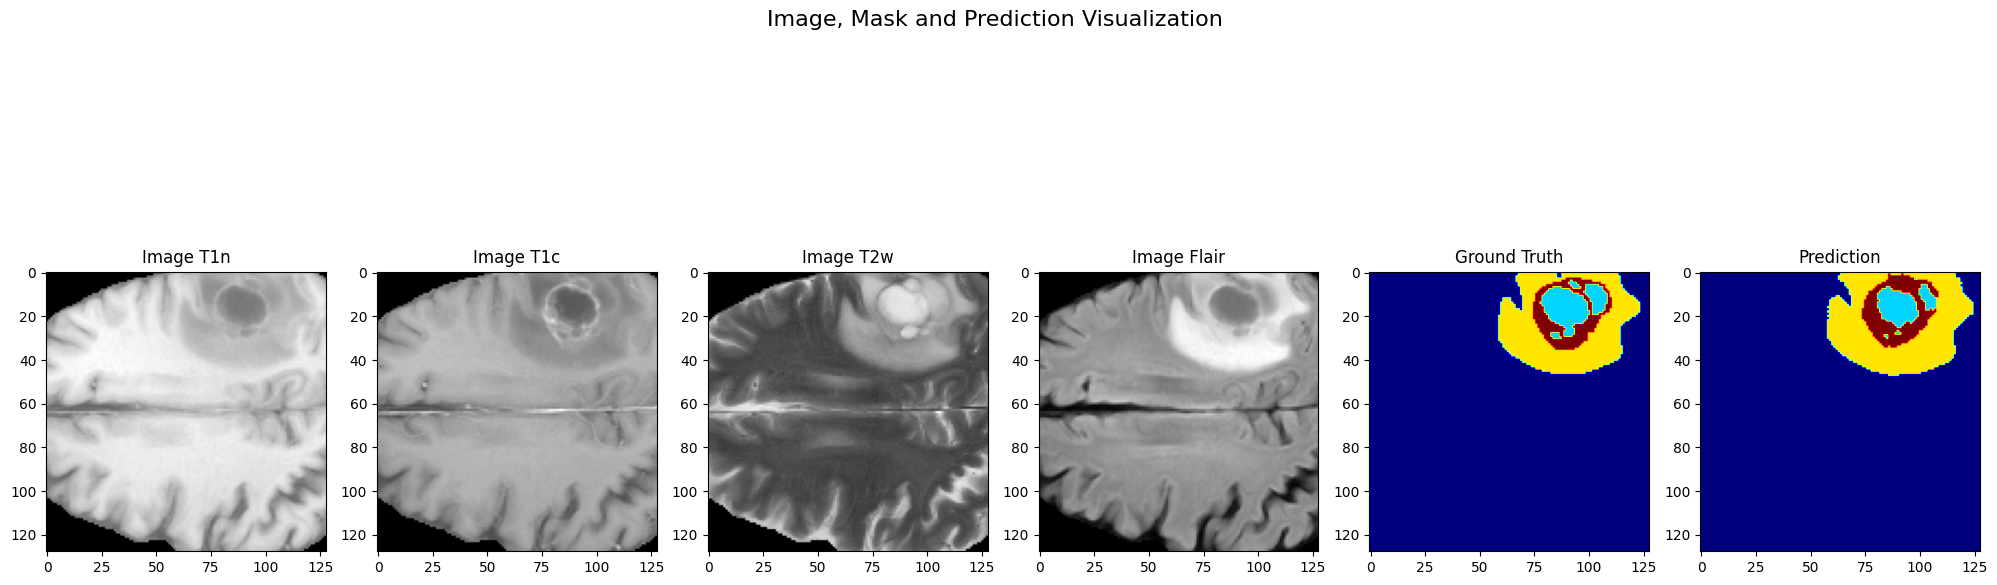

In [17]:
import matplotlib.pyplot as plt
import random

img_num = 3

# Load saved files
val_img = np.load(f"./predictions/val_img_{img_num}.npy")
val_gt = np.load(f"./predictions/val_gt_{img_num}.npy")
val_pred = np.load(f"./predictions/val_pred_{img_num}.npy")

val_gt = val_gt.argmax(axis = 1)
val_pred = val_pred.argmax(axis = 1)

# Split the combined image into 4 separate images
test_image_t1n = val_img[0, 0, :, :, :]
test_image_t1c = val_img[0, 1, :, :, :]
test_image_t2w = val_img[0, 2, :, :, :]
test_image_flair = val_img[0, 3, :, :, :]

# Select static slice
n_slice = 80
# n_slice = random.randint(0, 127)

# Create a grid of subplots with 1 row and 5 columns
fig, axes = plt.subplots(1, 6, figsize=(20, 8))
fig.suptitle('Image, Mask and Prediction Visualization', fontsize=16)

# Image T1n
axes[0].imshow(test_image_t1n[:, :, n_slice], cmap="gray")
axes[0].set_title('Image T1n')

# Image T1c
axes[1].imshow(test_image_t1c[ :, :, n_slice], cmap="gray")
axes[1].set_title('Image T1c')

# Image T2w
axes[2].imshow(test_image_t2w[:, :, n_slice], cmap="gray")
axes[2].set_title('Image T2w')

# Image Flair
axes[3].imshow(test_image_flair[:, :, n_slice], cmap="gray")
axes[3].set_title('Image Flair')

# Mask
axes[4].imshow(val_gt[0, :, :, n_slice], cmap=plt.cm.jet)
axes[4].set_title('Ground Truth')

axes[5].imshow(val_pred[0, :, :, n_slice], cmap=plt.cm.jet)
axes[5].set_title('Prediction')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


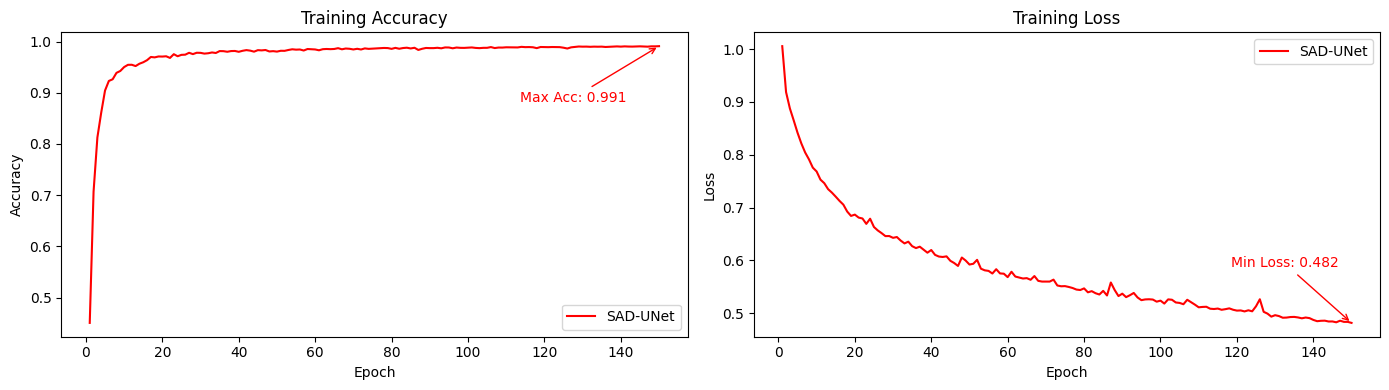

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV files
df = pd.read_csv('./training_results.csv')

# Convert Epoch to strings
df['Epoch'] = df['Epoch'].astype(str)

# Filter dataframe and epochs
df1 = df[df['Epoch'].str.contains('Validation') == False]
epochs1 = df1['Epoch'][df1['Epoch'].str.contains('Validation') == False]

# Extract data
acc1 = df1['Accuracy']
loss1 = df1['Loss']

start1 = int(epochs1.iloc[0])
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Plot accuracy
line_acc1, = ax1.plot(range(start1, len(epochs1) + start1), acc1, color='red', label='SAD-UNet')
ax1.set_title('Training Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()

# Find highest accuracy points
max_acc1 = acc1.max()
max_acc1_epoch = acc1.idxmax() + start1 - 14

# Plot loss
line_loss1, = ax2.plot(range(start1, len(epochs1) + start1), loss1, color='red', label='SAD-UNet')
ax2.set_title('Training Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()

# Find lowest loss points
min_loss1 = loss1.min()
min_loss1_epoch = loss1.idxmin() + start1 - 14

# Annotate highest points on plot 1
ax1.annotate(f'Max Acc: {max_acc1:.3f}', xy=(max_acc1_epoch, max_acc1), xytext=(-100, -40),
             textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'),
             color='red')

# Annotate lowest points on plot 2
ax2.annotate(f'Min Loss: {min_loss1:.3f}', xy=(min_loss1_epoch, min_loss1), xytext=(-87, 40),
             textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'),
             color='red')

# Adjust layout
plt.tight_layout()

plt.show()


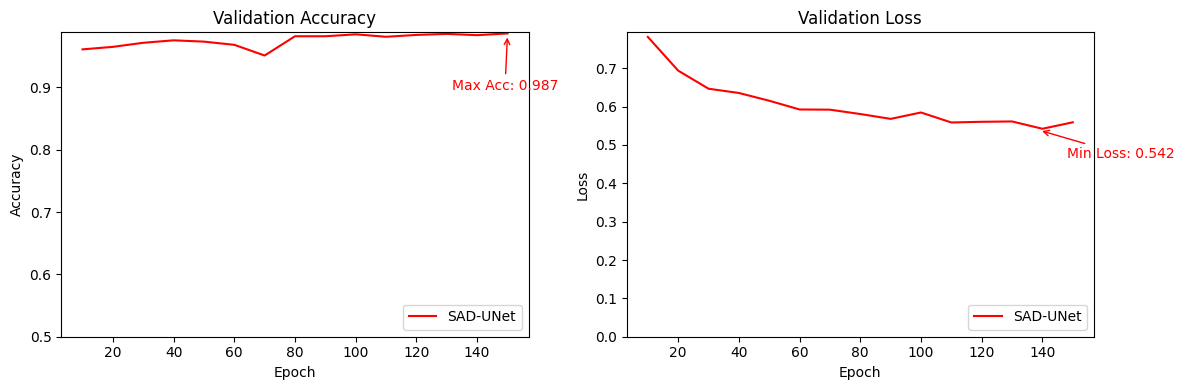

In [3]:

# Filter dataframe and epochs
df1 = df[df['Epoch'].str.contains('Validation')]
epochs1 = df1['Epoch'][df1['Epoch'].str.contains('Validation')]


# Extract starting epoch
start1 = 10

# Extract data
acc1 = df1['Accuracy']
loss1 = df1['Loss']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
line_acc1, = ax1.plot(range(start1, len(epochs1) * 10 + start1, 10), acc1, color='red', label='SAD-UNet')
ax1.set_title('Validation Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylim(bottom=0.5)
ax1.legend(loc='lower right')

# Find highest accuracy points
max_acc1 = acc1.max()

# Plot loss
line_loss1, = ax2.plot(range(start1, len(epochs1) * 10 + start1, 10), loss1, color='red', label='SAD-UNet')
ax2.set_title('Validation Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylim(bottom=0)
ax2.legend(loc='lower right')

# Find lowest loss points
min_loss1 = loss1.min()
# Annotate highest accuracy points for both subplots
ax1.annotate(f'Max Acc: {max_acc1:.3f}', xy=(acc1.idxmax() - 14, max_acc1 - 0.002), xytext=(-40, -40),
             textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'),
             color='red')

# Annotate lowest loss points for both subplots
ax2.annotate(f'Min Loss: {min_loss1:.3f}', xy=(loss1.idxmin() - 14, min_loss1- 0.004), xytext=(20, -20),
             textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'),
             color='red')

# Adjust layout
plt.tight_layout()

plt.show()


## Training and Validation Mean Dice

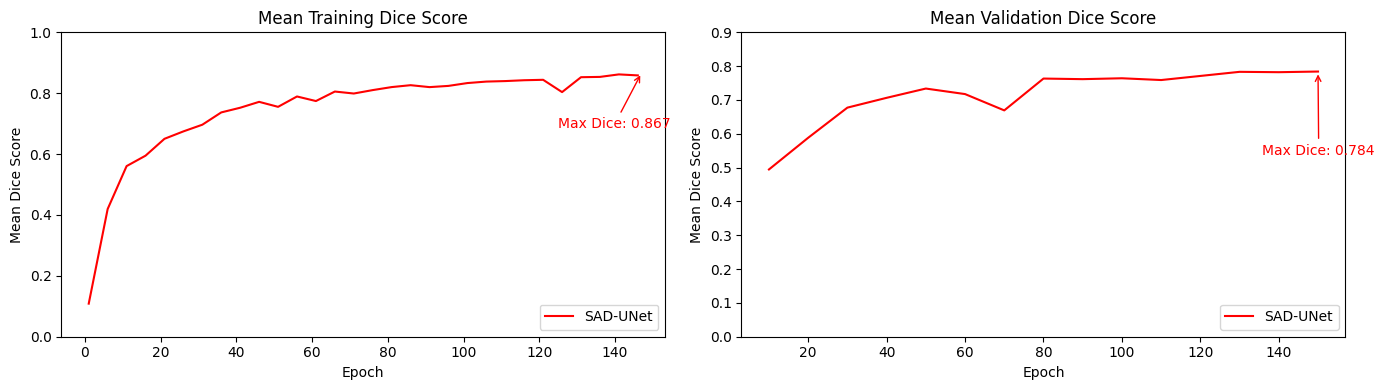

In [5]:
# Filter dataframe and epochs for training results
df1_train = df[~df['Epoch'].str.contains('Validation')]
epochs1_train = df1_train['Epoch']

# Extract starting epoch for training results
start1_train = int(epochs1_train.iloc[0])

# Calculate mean dice scores for training results
mean_dice1_train = df1_train[['Dice Coef (1)', 'Dice Coef (2)', 'Dice Coef (3)']].mean(axis=1)

# Filter dataframe and epochs for validation results
df1_val = df[df['Epoch'].str.contains('Validation')]
epochs1_val = df1_val['Epoch']

# Extract starting epoch for validation results
start1_val = 10

# Calculate mean dice scores for validation results
mean_dice1_val = df1_val[['Dice Coef (1)', 'Dice Coef (2)', 'Dice Coef (3)']].mean(axis=1)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# convert to numpy arrays if they are not
mean_dice1_train = np.array(mean_dice1_train)

# take every 5th value from these arrays
mean_dice1_train_smooth = mean_dice1_train[::5]

ax1.plot(range(start1_train, len(epochs1_train) + start1_train , 5), mean_dice1_train_smooth, color='red', label='SAD-UNet')
ax1.set_title('Mean Training Dice Score')
ax1.set_ylabel('Mean Dice Score')
ax1.set_xlabel('Epoch')
ax1.set_ylim(bottom=0, top=1)
ax1.legend(loc='lower right')

# Plot validation mean dice score
ax2.plot(range(start1_val, len(epochs1_val) * 10 + start1_val, 10), mean_dice1_val, color='red', label='SAD-UNet')
ax2.set_title('Mean Validation Dice Score')
ax2.set_ylabel('Mean Dice Score')
ax2.set_xlabel('Epoch')
ax2.set_ylim(bottom=0, top=0.9)
ax2.legend(loc='lower right')

# Find max dice scores for training
max_dice1_train = mean_dice1_train.max()

# Find max dice scores for validation
max_dice1_val = mean_dice1_val.max()

# Annotate highest dice scores for training subplot
ax1.annotate(f'Max Dice: {max_dice1_train:.3f}', xy=(np.argmax(mean_dice1_train) + start1_train - 3 , max_dice1_train), xytext=(-60, -40),
             textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'),
             color='red')

# Annotate highest dice scores for validation subplot
ax2.annotate(f'Max Dice: {max_dice1_val:.3f}', xy=(np.argmax(mean_dice1_val) * 10 + start1_val, max_dice1_val), xytext=(-40, -60),
             textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'),
             color='red')


# Adjust layout
plt.tight_layout()

plt.show()


## Training Metrics

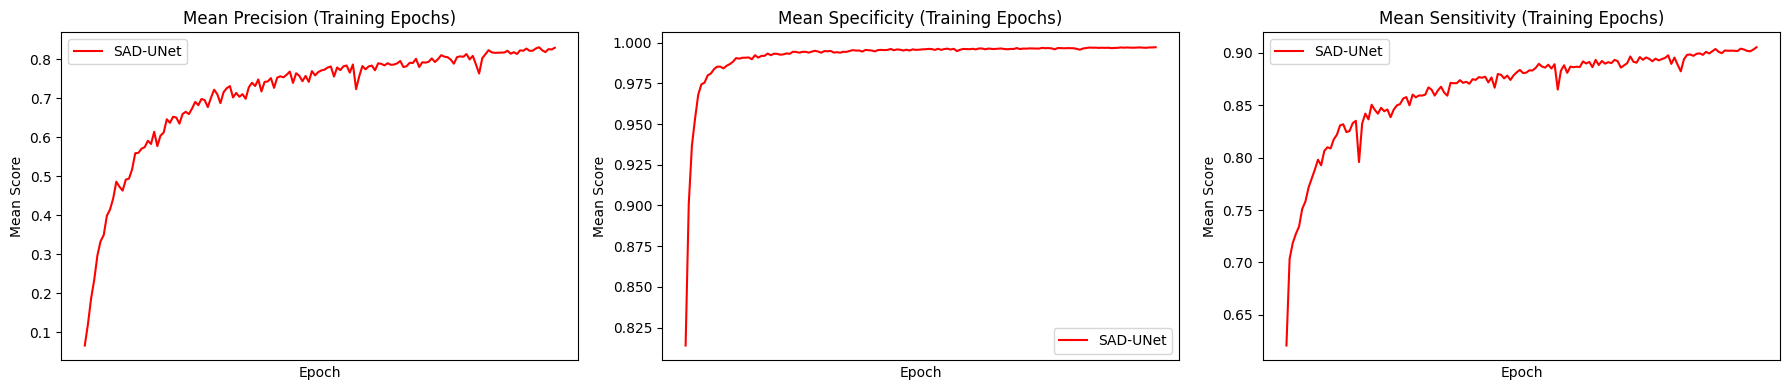

In [4]:
# Filter dataframe and epochs
train_df1 = df[~df['Epoch'].str.contains('Validation')]
train_epochs1 = train_df1['Epoch']

val_df1 = df[df['Epoch'].str.contains('Validation')]
val_epochs1 = val_df1['Epoch']


# Extract starting epoch
start_train1 = int(train_epochs1.iloc[0])

start_val1 = 10

# Calculate mean of metrics (Precision, Specificity, Sensitivity) from class 1 to 3
mean_precision_train1 = train_df1[['Precision (1)', 'Precision (2)', 'Precision (3)']].mean(axis=1)
mean_specificity_train1 = train_df1[['Specificity (1)', 'Specificity (2)', 'Specificity (3)']].mean(axis=1)
mean_sensitivity_train1 = train_df1[['Sensitivity (1)', 'Sensitivity (2)', 'Sensitivity (3)']].mean(axis=1)

mean_precision_val1 = val_df1[['Precision (1)', 'Precision (2)', 'Precision (3)']].mean(axis=1)
mean_specificity_val1 = val_df1[['Specificity (1)', 'Specificity (2)', 'Specificity (3)']].mean(axis=1)
mean_sensitivity_val1 = val_df1[['Sensitivity (1)', 'Sensitivity (2)', 'Sensitivity (3)']].mean(axis=1)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Determine max epoch for x-axis limit
max_epoch = int(train_epochs1.iloc[-1])

# Plot mean precision scores for training epochs
axes[0].plot(train_epochs1, mean_precision_train1, color='red', label='SAD-UNet')
axes[0].set_title('Mean Precision (Training Epochs)')
axes[0].set_ylabel('Mean Score')
axes[0].set_xlabel('Epoch')
axes[0].set_xticks(range(199, max_epoch + 1, 200))
axes[0].legend()

# Plot mean specificity scores for training epochs
axes[1].plot(train_epochs1, mean_specificity_train1, color='red', label='SAD-UNet')
axes[1].set_title('Mean Specificity (Training Epochs)')
axes[1].set_ylabel('Mean Score')
axes[1].set_xlabel('Epoch')
axes[1].set_xticks(range(199, max_epoch + 1, 200))
axes[1].legend()

# Plot mean sensitivity scores for training epochs
axes[2].plot(train_epochs1, mean_sensitivity_train1, color='red', label='SAD-UNet')
axes[2].set_title('Mean Sensitivity (Training Epochs)')
axes[2].set_ylabel('Mean Score')
axes[2].set_xlabel('Epoch')
axes[2].set_xticks(range(199, max_epoch + 1, 200))
axes[2].legend()


# Adjust layout
plt.tight_layout()

plt.show()


## Validation Metrics

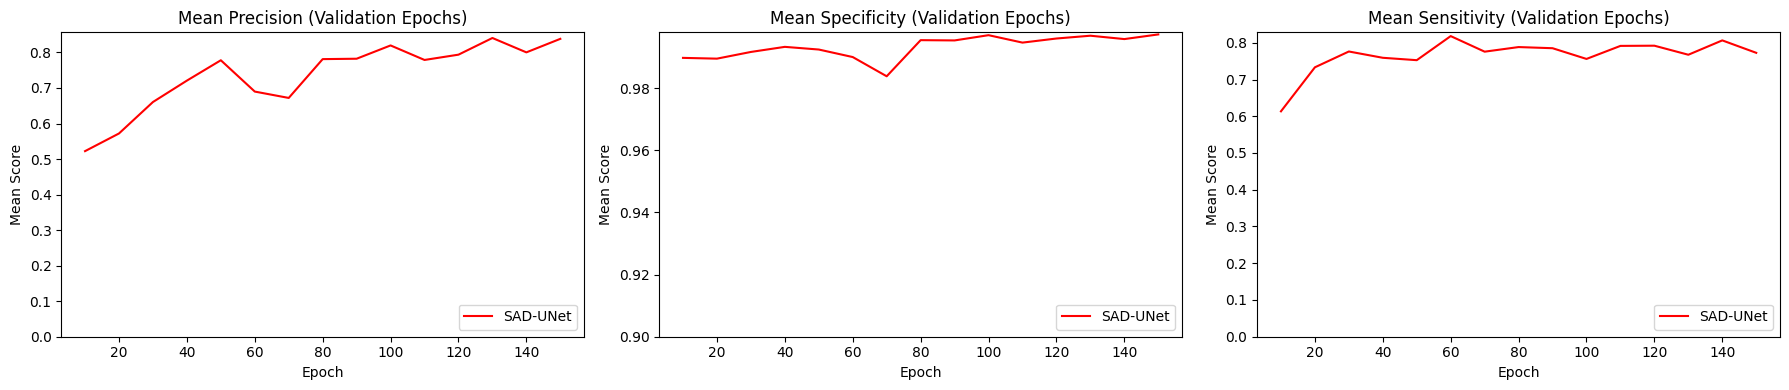

In [6]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Plot mean precision scores for validation epochs
axes[0].plot(range(start_val1, len(val_epochs1) * 10 + start_val1, 10), mean_precision_val1, color='red', label='SAD-UNet')
axes[0].set_title('Mean Precision (Validation Epochs)')
axes[0].set_ylabel('Mean Score')
axes[0].set_xlabel('Epoch')
axes[0].set_ylim(0)
axes[0].legend(loc='lower right')

# Plot mean specificity scores for validation epochs
axes[1].plot(range(start_val1, len(val_epochs1) * 10 + start_val1, 10), mean_specificity_val1, color='red', label='SAD-UNet')
axes[1].set_title('Mean Specificity (Validation Epochs)')
axes[1].set_ylabel('Mean Score')
axes[1].set_xlabel('Epoch')
axes[1].set_ylim(0.9)
axes[1].legend(loc='lower right')

# Plot mean sensitivity scores for validation epochs
axes[2].plot(range(start_val1, len(val_epochs1) * 10 + start_val1, 10), mean_sensitivity_val1, color='red', label='SAD-UNet')
axes[2].set_title('Mean Sensitivity (Validation Epochs)')
axes[2].set_ylabel('Mean Score')
axes[2].set_xlabel('Epoch')
axes[2].set_ylim(0)
axes[2].legend(loc='lower right')



# Adjust layout
plt.tight_layout()

plt.show()